<a href="https://colab.research.google.com/github/sanghoonsim/CSE535-Mobile-Computing/blob/main/Show-and-Tell-with-Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


# Image Captioning with visual attention
* This code is referred from https://www.tensorflow.org/tutorials/text/image_captioning


## Intro & Import Libraries













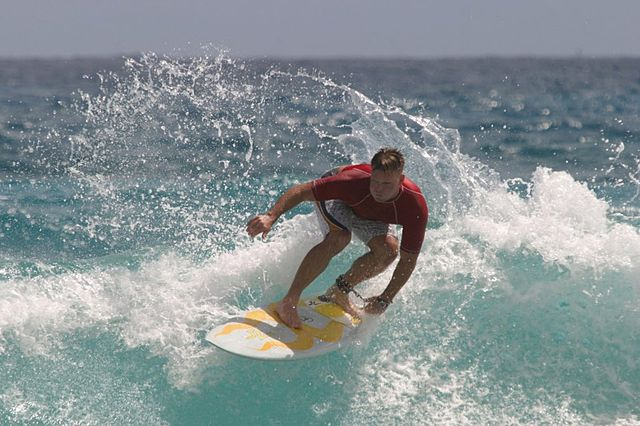

* Given the image above, the application should give us a caption like **"A surver riding on a wave"**
* We will cover an attention-based model, which sees what parts of the image the model focuses on as it generates a catpion
* Dataset: **MS-COCO datasets**

* In this example, the first captioins is about **30,000** for about **20,000** images since there are multiple captions per image in the dataset

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Download Dataset(Implemented)

* Data contains over 82,000 images and each of images has at least 5 different caption annotations.

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

## Optional: limit the size of the traning set

* To speed up the processing, modify the dataset for us to use only 30,000 captions and their corresponding images to train our model. 
* However, more data usage will give us more accurate result

In [ ]:
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

# open file instance 'annotation_file' with named as 'annotations'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)

for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

# In the dictionary, data is stored as below:
# {image_path: cpation}

#-------------------------------------------------------------------------------------------------------------#
# Example of val
# {'image_id': 170706, 'id': 804603, 'caption': 'An airplane parked in front of the terminal at the airport.'}
# {'image_id': 543517, 'id': 804665, 'caption': 'United States Marine aircraft sitting on a runway.'}
# ...

# Example of cpation
# <start> A very clean and well decorated empty bathroom <end>

# Example of image_path
# /content/train2014/COCO_train2014_000000318556.jpg

In [ ]:
image_paths = list(image_path_to_caption.keys()) # Retrieve the image path from the dictionary
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [ ]:
# Define matchings between the captions and images as training data
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list)) # There are about 5 captions per an image, it varies though
  # By using 'extend' instead of 'append', the element in the each list will be stored as individually in the img_name_vector

  # The length of each list in the 'img_name_vector' is the same as the number of the corresponding captions
  # Since there are 5 captions, for this time, there are 5 same paths
  # But there will be the different captions
  # image_path : ['/content/train2014/COCO_train2014_000000162769.jpg', 
  #               '/content/train2014/COCO_train2014_000000162769.jpg', 
  #               '/content/train2014/COCO_train2014_000000162769.jpg', 
  #               '/content/train2014/COCO_train2014_000000162769.jpg', 
  #               '/content/train2014/COCO_train2014_000000162769.jpg']



# FYI: Difference between 'append' and 'extend' ??

<start> A barbecue sandwich served with crinkle cut fries <end>


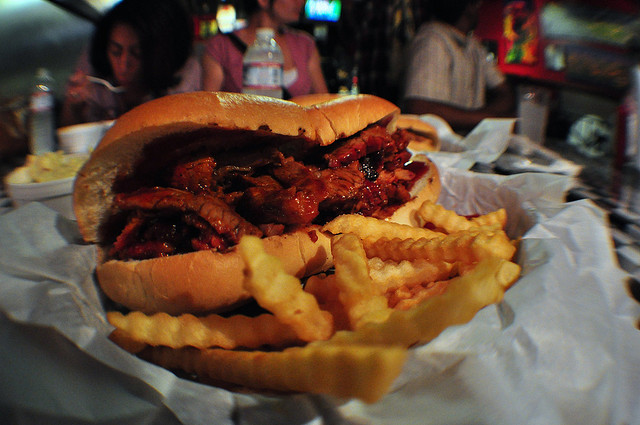

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

<start> a sandwich sits next to some fries  <end>


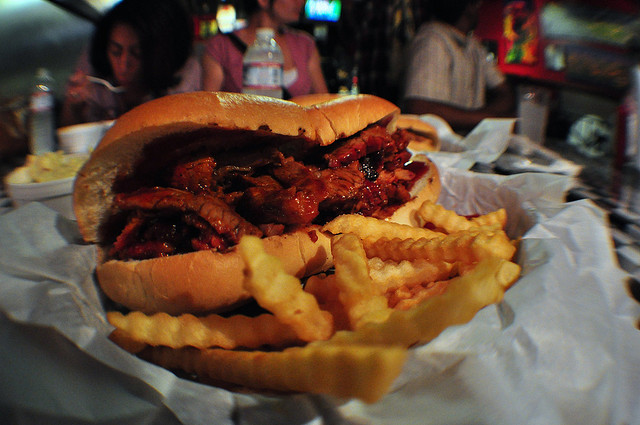

In [ ]:
# Same image but different captions
print(train_captions[1])
Image.open(img_name_vector[1])

## Preprocess the images using InceptionV3



1.   **Convert the images into InceptionV3's expected format:**\
      * Resizing the image to 299px * 299px
      * Preprocess the images using the **preprocess_input** method to normalize the image to make the range of pixel to -1 to 1, which matches for the InceptionV3 format


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
# Testing the function
t1, t2 = load_image(image_paths[0])
t1, t2

(<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
 array([[[ 0.41795528,  0.8898045 ,  0.46183085],
         [ 0.4741701 ,  0.93106425,  0.5575007 ],
         [ 0.48480237,  0.99227166,  0.65739393],
         ...,
         [-0.87874246, -0.94582945, -0.9234671 ],
         [-0.89624864, -0.9317609 , -0.9173714 ],
         [-0.9266572 , -0.9423435 , -0.91881406]],
 
        [[ 0.38451052,  0.86238384,  0.4825616 ],
         [ 0.4544822 ,  0.9100007 ,  0.5770917 ],
         [ 0.45351171,  0.9666766 ,  0.66854227],
         ...,
         [-0.8759388 , -0.9536789 , -0.9263589 ],
         [-0.9015629 , -0.9440846 , -0.93066686],
         [-0.903463  , -0.93402237, -0.9055352 ]],
 
        [[ 0.33430052,  0.8263953 ,  0.50421345],
         [ 0.40769553,  0.87332606,  0.58823526],
         [ 0.4033476 ,  0.92491627,  0.6800184 ],
         ...,
         [-0.8535798 , -0.9465928 , -0.9286973 ],
         [-0.8806741 , -0.9454174 , -0.9237369 ],
         [-0.88083124, -0.9215096 , -0.9090135

## Initialize InceptionV3 and load the pretrained Imagenet weights

2.   Create a **tf.keras** model where the output layer is the last convolutional layer in the InceptionV3 architecture
    * Shape: 8 * 8 * 2048
    * Forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector)
    * After all the images are passed through the network, you save the dictionary to disk



In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 2s 0us/step


## Caching the features extracted from InceptionV3

* Caching the output of pre-processing by InceptionV3 to disk
* Cashing the output in RAM would be faster but also memory intensive, requiring 8*8*2048 floats per image

In [ ]:
!pip install tqdm

In [ ]:
# To see the progress bar
from tqdm import tqdm

In [ ]:
print(img_name_vector[:10])

['/content/train2014/COCO_train2014_000000563659.jpg', '/content/train2014/COCO_train2014_000000563659.jpg', '/content/train2014/COCO_train2014_000000563659.jpg', '/content/train2014/COCO_train2014_000000563659.jpg', '/content/train2014/COCO_train2014_000000563659.jpg', '/content/train2014/COCO_train2014_000000091928.jpg', '/content/train2014/COCO_train2014_000000091928.jpg', '/content/train2014/COCO_train2014_000000091928.jpg', '/content/train2014/COCO_train2014_000000091928.jpg', '/content/train2014/COCO_train2014_000000091928.jpg']


In [ ]:
# Get unique images by using 'set' for the list
encode_train = sorted(set(img_name_vector)) # the vector that defined in the previous stage containing the name(path) of the images

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [02:10<00:00,  2.87it/s]


In [ ]:
print(image_dataset)

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>


## Preprocess and tokenize the captions

* Tokenize: split the captions by space  Ex) "I am playing" => "I", "am", "playing"
* Limit the vocabulary size to 5,000 words to save memory resource. Replace all other words with the token <UNK>, unkown
* Create word-to-index and index-to-word mappings
* Pad all sequences to be the same length as the longest one

* How Tokenizer works

```python
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [
  'I love my dog',
  'I love my cat',
  'This neighborhood is quiet and nice.',
  'After I settle in, I’ll invite you for a coffee.'
]
tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_dic = tokenizer.word_index
print(word_dic) 
# {'i': 1, 'love': 2, 'my': 3, 'dog': 4, 'cat': 5, 'this': 6, 'neighborhood': 7, 'is': 8, 'quiet': 9, 'and': 10, 'nice': 11, 'after': 12, 'settle': 13, 'in': 14, 'i’ll': 15, 'invite': 16, 'you': 17, 'for': 18, 'a': 19, 'coffee': 20}

sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)
# [[1, 2, 3, 4], [1, 2, 3, 5], [6, 7, 8, 9, 10, 11], [12, 1, 13, 14, 15, 16, 17, 18, 19, 20]]
padded = pad_sequences(sequences)
print(padded)
# [[ 0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  1  2  3  5]
 [ 0  0  0  0  6  7  8  9 10 11]
 [12  1 13 14 15 16 17 18 19 20]]
```

In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000

# Creat a Tokenizer instance
# - num_words: set the number of vocabs to use in the order in which it appears more frequently
# - oov_token: set uncontrolled vocab as '<unk>'
# - filters: set words to filter out
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

# Use 'fit_on_texts' to create key-value dictionary
tokenizer.fit_on_texts(train_captions) 
#print(tokenizer.word_index)
# {'<unk>': 1, 'a': 2, '<start>': 3, '<end>': 4, 'on': 5, 'of': 6, 'the': 7, ... 'changebag': 7844, 'sequins': 7845}

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
#print(tokenizer.index_word)
# {1: '<unk>', 2: 'a', 3: '<start>', 4: '<end>', 5: 'on', 6: 'of', 7: 'the', ... , 7845: 'sequins', 0: '<pad>'}

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
#print(tokenizer.texts_to_sequences(train_captions))
# [[3, 2, 113, 812, 9, 2, 59, 165, 162, 4], [3, 2, 1518, 11, 18, 2, 377, 83, 398, 4],... ]

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically

# By padding each sequece vector to the max length(50), every vector maintains the same length
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print(len(cap_vector[0]))
#[[   3    2  113 ...    0    0    0] --- len:50
# [   3    2 1518 ...    0    0    0]
# [   3    2   59 ...    0    0    0]
# ...
# [   3    2  850 ...    0    0    0]
# [   3    2   80 ...    0    0    0]
# [   3   15  136 ...    0    0    0]]

51


In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

51

## Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24012, 24012, 6004, 6004)

## Create a tf.data dataset for training

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9029
Epoch 1 Batch 100 Loss 1.0865
Epoch 1 Batch 200 Loss 0.9330
Epoch 1 Batch 300 Loss 0.8677
Epoch 1 Loss 0.984022
Time taken for 1 epoch 332.88 sec

Epoch 2 Batch 0 Loss 0.8557
Epoch 2 Batch 100 Loss 0.7583
Epoch 2 Batch 200 Loss 0.7375
Epoch 2 Batch 300 Loss 0.7754
Epoch 2 Loss 0.751713
Time taken for 1 epoch 184.54 sec

Epoch 3 Batch 0 Loss 0.6853
Epoch 3 Batch 100 Loss 0.7252
Epoch 3 Batch 200 Loss 0.6856
Epoch 3 Batch 300 Loss 0.6561
Epoch 3 Loss 0.678202
Time taken for 1 epoch 183.36 sec

Epoch 4 Batch 0 Loss 0.6614
Epoch 4 Batch 100 Loss 0.6351
Epoch 4 Batch 200 Loss 0.6381
Epoch 4 Batch 300 Loss 0.6320
Epoch 4 Loss 0.630867
Time taken for 1 epoch 183.57 sec

Epoch 5 Batch 0 Loss 0.5775
Epoch 5 Batch 100 Loss 0.5407
Epoch 5 Batch 200 Loss 0.5319
Epoch 5 Batch 300 Loss 0.6134
Epoch 5 Loss 0.591383
Time taken for 1 epoch 183.82 sec

Epoch 6 Batch 0 Loss 0.5844
Epoch 6 Batch 100 Loss 0.5485
Epoch 6 Batch 200 Loss 0.5272
Epoch 6 Batch 300 Loss 0.5168
Epoch 6

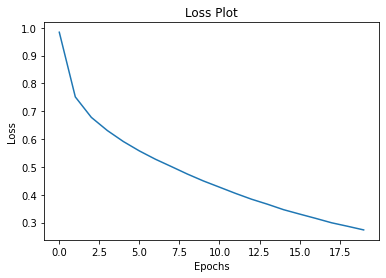

In [50]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [51]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [52]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a person standing operating a cell phone in a room <end>
Prediction Caption: a man in a living room holding a remote <unk> <end>


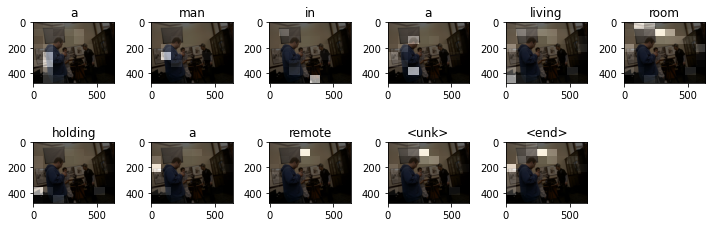

In [53]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

73728/64400 [==================================] - 0s 5us/step
Prediction Caption: a young boy on a surf board on a nice ocean doing a trick <end>


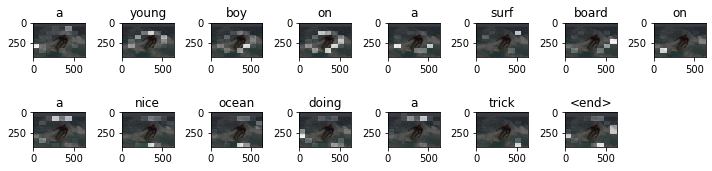

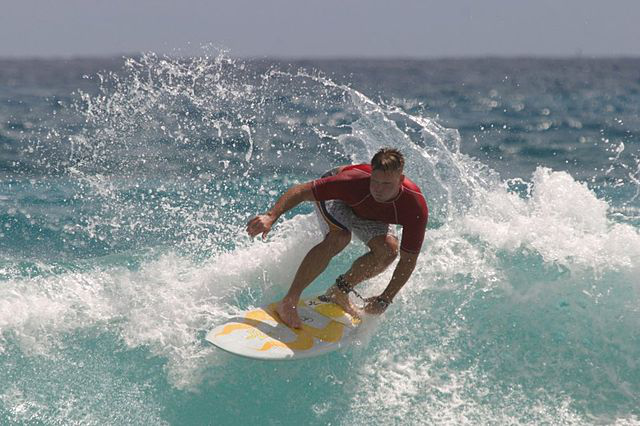

In [54]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)